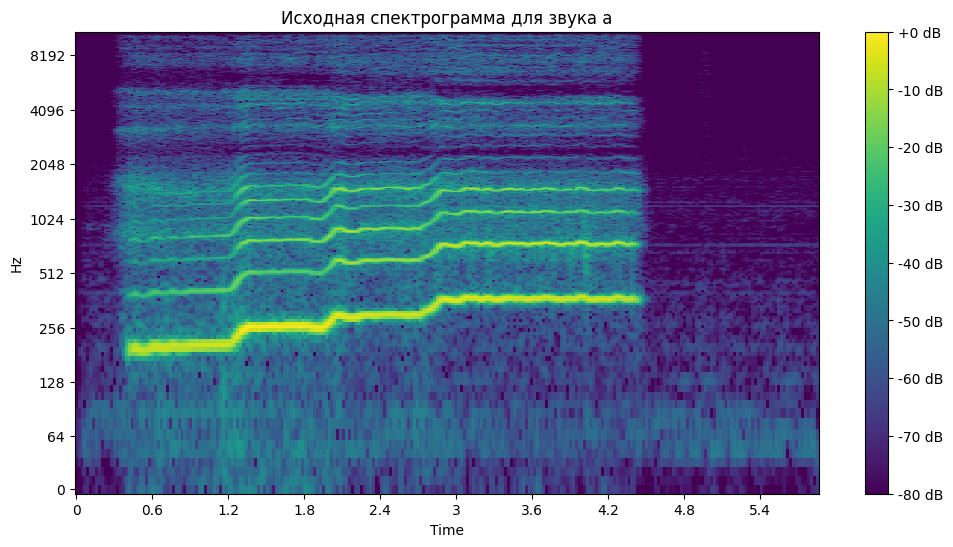

Минимальная частота голоса для звука а: 0.0 Гц
Максимальная частота голоса для звука а: 10669.7021484375 Гц
Основной тон для звука а: 258.3984375 Гц


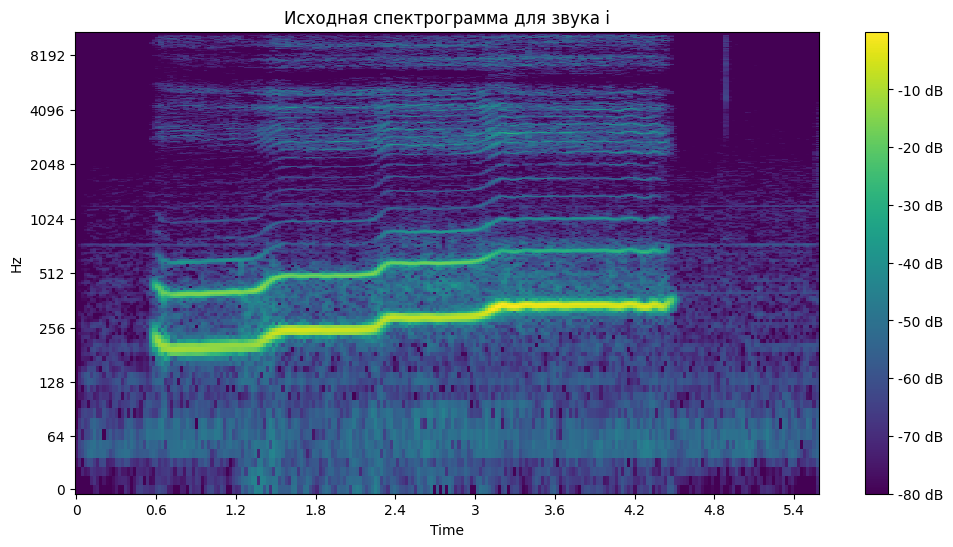

Минимальная частота голоса для звука i: 0.0 Гц
Максимальная частота голоса для звука i: 10605.1025390625 Гц
Основной тон для звука i: 0.0 Гц


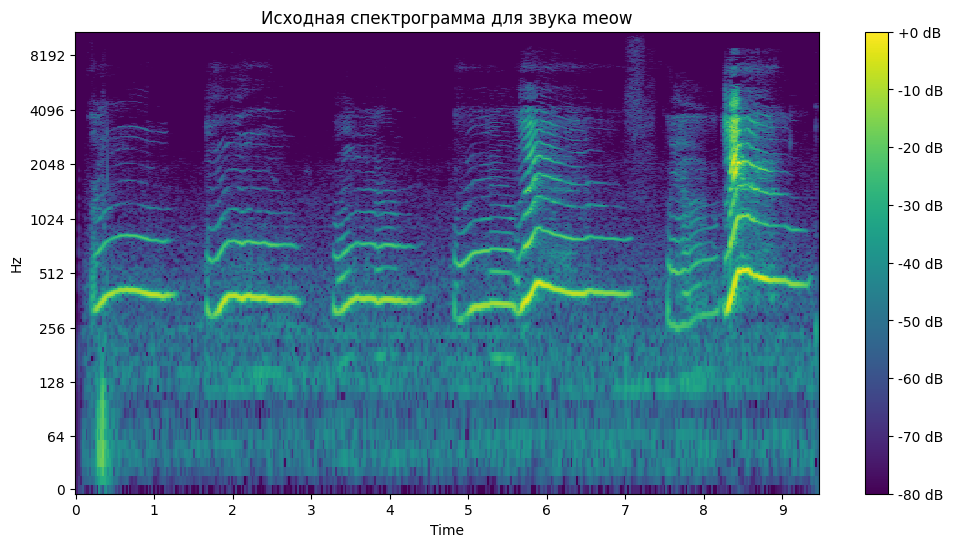

Минимальная частота голоса для звука meow: 0.0 Гц
Максимальная частота голоса для звука meow: 10314.404296875 Гц
Основной тон для звука meow: 2088.720703125 Гц


In [4]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display

def compute_spectrogram(audio_signal, sample_rate):
    n_fft = 2048
    hop_length = 512
    window = np.hanning(n_fft)
    stft_matrix = librosa.stft(audio_signal, n_fft=n_fft, hop_length=hop_length, window=window)
    magnitude_spectrogram = np.abs(stft_matrix)
    log_spectrogram = librosa.amplitude_to_db(magnitude_spectrogram, ref=np.max)
    return log_spectrogram, sample_rate, n_fft

def plot_and_save_spectrogram(log_spectrogram, sample_rate, n_fft, title):
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()

def calculate_voice_freq_range(log_spectrogram, sample_rate, n_fft):
    min_freq_bin = np.min(np.where(log_spectrogram > -60)[0])
    max_freq_bin = np.max(np.where(log_spectrogram > -60)[0])
    min_freq_hz = min_freq_bin * sample_rate / n_fft
    max_freq_hz = max_freq_bin * sample_rate / n_fft
    return min_freq_hz, max_freq_hz

def calculate_fundamental_frequency(log_spectrogram, sample_rate, n_fft):
    harmonic_product_spectrum = np.prod(log_spectrogram, axis=1)
    fundamental_frequency = np.argmax(harmonic_product_spectrum) * sample_rate / n_fft
    return fundamental_frequency

def calculate_formants(log_spectrogram, sample_rate, n_fft):
    time_step = int(0.1 * sample_rate / 512)  # Time step in indices
    freq_step = 50  # Frequency step in Hz

    # Divide into time segments
    time_slices = range(0, log_spectrogram.shape[1], time_step)
    formant_frequencies = []
    for j in range(len(time_slices) - 1):
        start = time_slices[j]
        end = time_slices[j + 1]
        segment = log_spectrogram[:, start:end]

        # Find the three peaks with the highest energy in the segment
        freq_bins = np.arange(segment.shape[0]) * sample_rate / n_fft
        peaks = np.argsort(np.max(segment, axis=1))[-3:]
        formant_frequencies.append([freq_bins[peak] for peak in peaks])

    return formant_frequencies

def main():
    filenames = ["a.wav", "i.wav", "meow.wav"]
    labels = ["звука а", "звука i", "звука meow"]

    for i in range(len(filenames)):
        audio_file = filenames[i]
        audio_data, sample_rate = librosa.load(audio_file)

        # Normalize audio data to avoid overflow issues
        audio_data = audio_data / np.max(np.abs(audio_data))

        # Compute spectrogram
        log_spectrogram, sample_rate, n_fft = compute_spectrogram(audio_data, sample_rate)

        # Plot and save the spectrogram
        plot_and_save_spectrogram(log_spectrogram, sample_rate, n_fft, f'Исходная спектрограмма для {labels[i]}')

        # Calculate voice frequency range
        min_freq, max_freq = calculate_voice_freq_range(log_spectrogram, sample_rate, n_fft)
        print(f"Минимальная частота голоса для {labels[i]}: {min_freq} Гц")
        print(f"Максимальная частота голоса для {labels[i]}: {max_freq} Гц")

        # Calculate fundamental frequency
        fundamental_freq = calculate_fundamental_frequency(log_spectrogram, sample_rate, n_fft)
        print(f"Основной тон для {labels[i]}: {fundamental_freq} Гц")

        # Calculate formants
        formants = calculate_formants(log_spectrogram, sample_rate, n_fft)

        with open(f"{audio_file[:-4]}_results.txt", "w", encoding="utf-8") as f:
            f.write(f"Результаты анализа звукового файла: {audio_file}\n\n")
            f.write(f"Минимальная частота голоса: {min_freq} Гц\n")
            f.write(f"Максимальная частота голоса: {max_freq} Гц\n\n")
            f.write(f"Основной тон: {fundamental_freq} Гц\n\n")
            f.write("Три самые сильные форманты:\n")
            for idx, formant in enumerate(formants, start=1):
                f.write(f"{idx}. {formant} Гц\n")

if __name__ == "__main__":
    main()
